In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import iris
import geopandas

In [2]:
from dask.distributed import Client

In [3]:
client = Client()
client

2025-01-08 10:06:58,854 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-01-08 10:06:58,857 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-01-08 10:06:58,864 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0109.gadi.nci.org.au/51465/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0109.gadi.nci.org.au/51465/proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45185,Workers: 14
Dashboard: /node/gadi-cpu-bdw-0109.gadi.nci.org.au/51465/proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42841,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0109.gadi.nci.org.au/51465/proxy/43119/status,Memory: 0 B
Nanny: tcp://127.0.0.1:38347,


In [45]:
def load_access_rns(fname,var_name):

    data = iris.load(fname, var_name)                  
    data_da = xr.DataArray.from_iris(data[0])

    return data_da

path = "/scratch/gb02/ab4502/cylc-run/u-dg768_ostia/share/cycle/20170101T0000Z/CAPE-k/CAPE-k_1/RAL3P2/um/"


In [ ]:
#LOAD DATA FROM PVERB
fnames = [path+"umnsaa_pverb000",
          path+"umnsaa_pverb012"]
var_name = "air_pressure_at_sea_level"
pres = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")

In [13]:
#LOAD DATA FROM PVERA
fnames = [path+"umnsaa_pvera000",
          path+"umnsaa_pvera012"]
var_name = "x_wind"
u_ds = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")
var_name = "y_wind"
v_ds = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")
var_name = "surface_temperature"
ts = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")
wind_ds = xr.Dataset({"u":u_ds,"v":v_ds})

In [ ]:
#LOAD DATA FROM PVERC
fnames = [path+"umnsaa_pverc000",
          path+"umnsaa_pverc012"]
var_name = "x_wind"
u_ds = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")

var_name = "y_wind"
v_ds = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")

var_name = "upward_air_velocity"
w_ds = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")

pwind_ds = xr.Dataset({"u":u_ds,"v":v_ds,"w":w_ds.interp(longitude=v_ds.longitude,latitude=v_ds.latitude)})

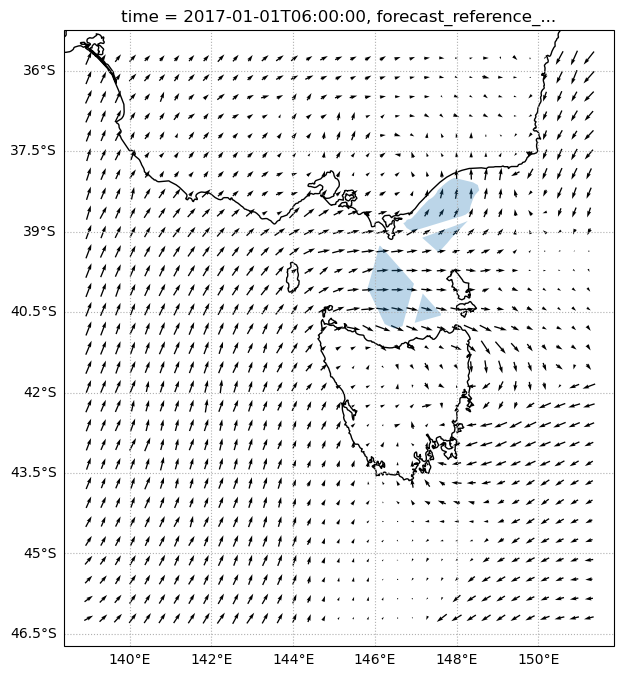

In [94]:
plt.figure(figsize=[12,8])

t="2017-01-01 06:00"
step=40

offshore_regions = geopandas.read_file("/g/data/gb02/ab4502/coastline_data/Offshore_Renewable_Energy_Infrastructure_Regions/Offshore_Renewable_Energy_Infrastructure_Regions.shp")

ax=plt.axes(projection=ccrs.PlateCarree())
wind_ds.sel(time=t).squeeze().isel(latitude=slice(0,-1,step),longitude=slice(0,-1,step)).plot.quiver(x="longitude",y="latitude",u="u",v="v")
geopandas.GeoDataFrame(offshore_regions).loc[[1],"geometry"].plot(ax=ax,alpha=0.3)
geopandas.GeoDataFrame(offshore_regions).loc[[2],"geometry"].plot(ax=ax,alpha=0.3)
geopandas.GeoDataFrame(offshore_regions).loc[[3],"geometry"].plot(ax=ax,alpha=0.3)
geopandas.GeoDataFrame(offshore_regions).loc[[13],"geometry"].plot(ax=ax,alpha=0.3)
geopandas.GeoDataFrame(offshore_regions).loc[[14],"geometry"].plot(ax=ax,alpha=0.3)
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":")
#ax.text(152.3,-32.6,"Hunter",color="tab:blue",fontdict={"weight":"bold","size":12})
#ax.text(151.3,-34.1,"Illawarra",color="tab:blue",fontdict={"weight":"bold","size":12})

#plt.title("Sydney 1 km 10 m winds (2017-01-01 06:00)")

In [ ]:
#LOAD DATA FROM PA
fnames = [path+"umnsaa_pa000"]
var_name = "land_binary_mask"
lsm = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")

var_name = "x_wind"
u_rho_ds = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")

var_name = "y_wind"
y_rho_ds = xr.concat([load_access_rns(f,var_name) for f in fnames],dim="time")

rho_wind_ds = xr.merge([u_rho_ds.interp(longitude=lsm.longitude),y_rho_ds.interp(latitude=lsm.latitude)],compat="override").swap_dims({"model_level_number":"level_height"})

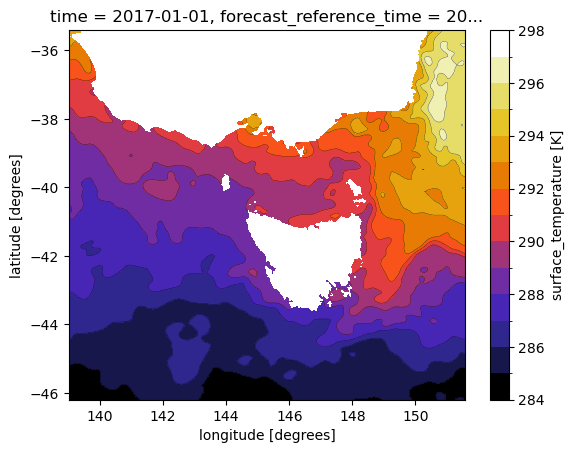

In [43]:
xr.plot.contourf(ts.sel(time=t).where(lsm==0,np.nan).squeeze(),levels=15,vmin=284,vmax=298, cmap="CMRmap")
xr.plot.contour(ts.sel(time=t).where(lsm==0,np.nan).squeeze(),levels=15,vmin=284,vmax=298, colors="k", linewidths=0.2)

In [253]:
import wrf
t="2017-01-01 03:00"
y_wind_interp = wrf.interplevel(rho_wind_ds.y_wind.sel(time=t).squeeze(), rho_wind_ds.altitude, np.linspace(0,5000,50), meta=False)
y_wind_interp_ds = xr.DataArray(
    y_wind_interp,dims=["height","lat","lon"],coords={"lat":rho_wind_ds.latitude.values,"lon":rho_wind_ds.longitude.values,"height":np.linspace(0,5000,50)})

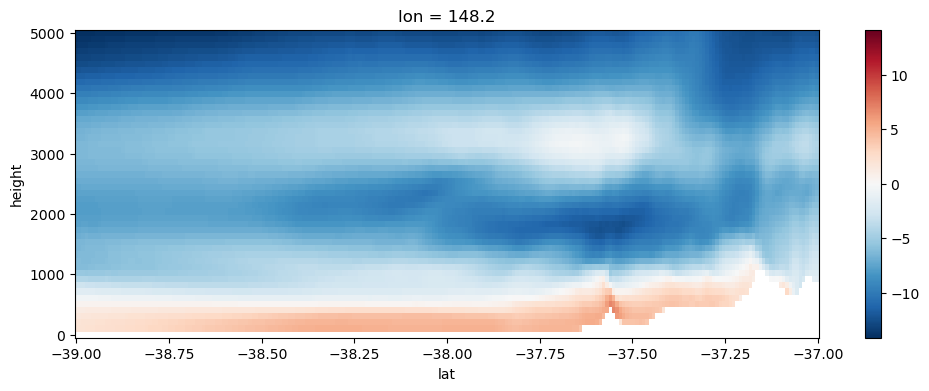

In [254]:
plt.figure(figsize=[12,4])

lat = slice(-39,-37)
lons = 148.2
heights = slice(0,6000)

y_wind_interp_ds.sel(lon=lons,method="nearest")\
        .sel(lat=lat,height=heights).plot()

(0.0, 5000.0)

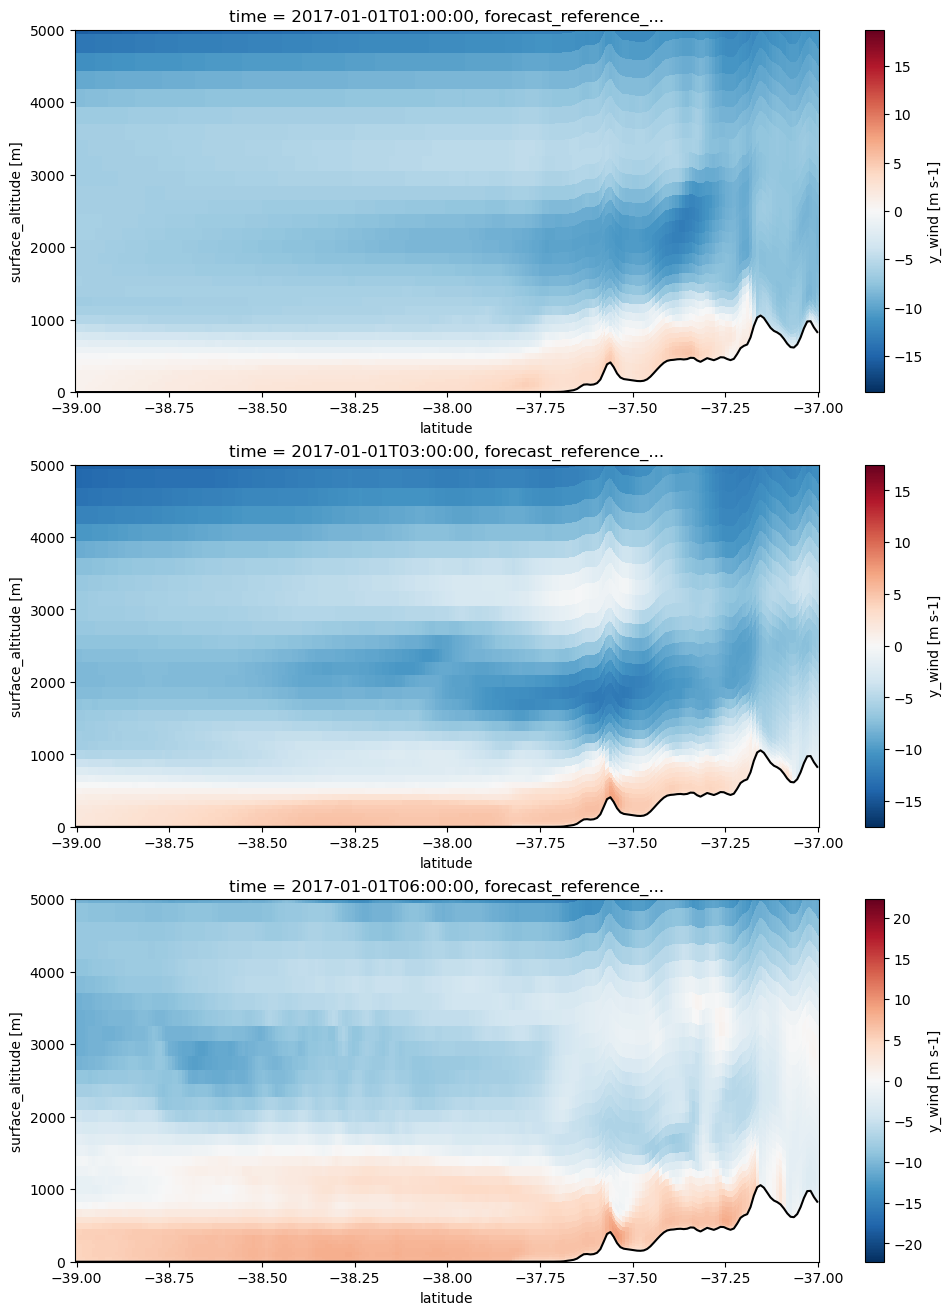

In [175]:
plt.figure(figsize=[12,16])

lat = slice(-39,-37)
lons = 148.2
heights = slice(0,6000)

plt.subplot(3,1,1)
t="2017-01-01 00:00"
rho_transect = rho_wind_ds.sel(time=t,longitude=lons,method="nearest")\
        .sel(latitude=lat,level_height=heights)
rho_transect["level_height"] = rho_transect["level_height"] + rho_transect["surface_altitude"]
rho_transect.y_wind.plot(x="latitude",y="level_height",cmap="RdBu_r")
rho_wind_ds.sel(time=t,longitude=lons,method="nearest")\
        .sel(latitude=lat).surface_altitude.plot(color="k")
plt.ylim([heights.start,heights.stop-1000])

plt.subplot(3,1,2)
t="2017-01-01 03:00"
rho_transect = rho_wind_ds.sel(time=t,longitude=lons,method="nearest")\
        .sel(latitude=lat,level_height=heights)
rho_transect["level_height"] = rho_transect["level_height"] + rho_transect["surface_altitude"]
rho_transect.y_wind.plot(x="latitude",y="level_height",cmap="RdBu_r")
rho_wind_ds.sel(time=t,longitude=lons,method="nearest")\
        .sel(latitude=lat).surface_altitude.plot(color="k")
plt.ylim([heights.start,heights.stop-1000])

plt.subplot(3,1,3)
t="2017-01-01 06:00"
rho_transect = rho_wind_ds.sel(time=t,longitude=lons,method="nearest")\
        .sel(latitude=lat,level_height=heights)
rho_transect["level_height"] = rho_transect["level_height"] + rho_transect["surface_altitude"]
rho_transect.y_wind.plot(x="latitude",y="level_height",cmap="RdBu_r")
rho_wind_ds.sel(time=t,longitude=lons,method="nearest")\
        .sel(latitude=lat).surface_altitude.plot(color="k")
plt.ylim([heights.start,heights.stop-1000])

In [176]:
rho_transect = rho_wind_ds.sel(time=t,longitude=lons,method="nearest")\
        .sel(latitude=lat,level_height=heights)

In [255]:
rho_transect

<xarray.Dataset> Size: 150kB
Dimensions:                  (level_height: 41, latitude: 223)
Coordinates:
    time                     datetime64[ns] 8B 2017-01-01T06:00:00
    model_level_number       (level_height) int64 328B 1 2 3 4 5 ... 38 39 40 41
  * latitude                 (latitude) float32 892B -39.0 -38.99 ... -37.0
    forecast_reference_time  datetime64[ns] 8B ...
    forecast_period          timedelta64[ns] 8B 06:00:00
  * level_height             (level_height) float64 328B 2.5 11.07 ... 5.917e+03
    sigma                    (level_height) float64 328B ...
    surface_altitude         (latitude) float64 2kB 0.0 0.0 0.0 ... 892.8 828.1
    altitude                 (level_height, latitude) float64 73kB 2.5 ... 6....
    longitude                float64 8B 148.2
Data variables:
    x_wind                   (level_height, latitude) float32 37kB dask.array<chunksize=(1, 223), meta=np.ndarray>
    y_wind                   (level_height, latitude) float32 37kB dask.array<chunksize=(1, 223), meta=np.ndarray>
Attributes:
    standard_name:  x_wind
    units:          m s-1
    source:         Data from Met Office Unified Model
    um_version:     13.0
    STASH:          m01s00i002

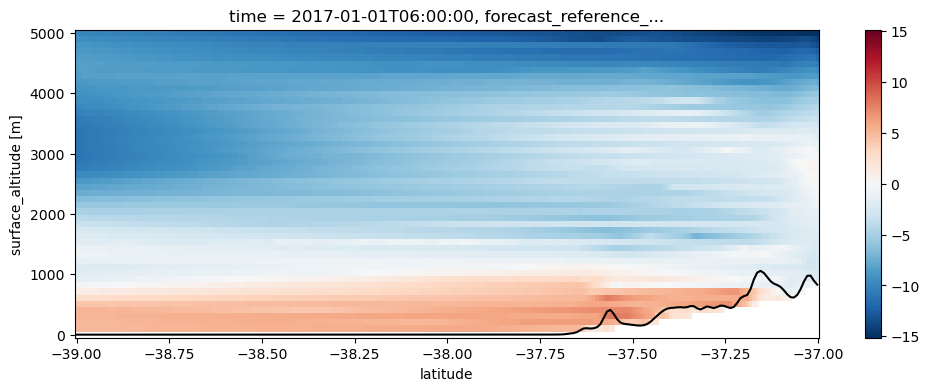

In [247]:
import scipy

xx,yy = np.meshgrid(rho_transect.latitude.values,rho_transect.level_height.values)

#points = np.array([xx.flatten(),yy.flatten()]).T
points = (xx.flatten(), rho_transect.altitude.values.flatten())
#points = 
values = rho_transect.y_wind.values.flatten()

xx_i,yy_i = np.meshgrid(rho_transect.latitude.values,np.linspace(0,5000,50))
#xi = np.array([xx_i.flatten(),yy_i.flatten()]).T
xi = (xx_i.flatten(),yy_i.flatten())


plt.figure(figsize=[12,4])
xr.DataArray(scipy.interpolate.griddata(points,values,xi).reshape(xx_i.shape),
             dims=("height","latitude"),coords={"height":np.linspace(0,5000,50),"latitude":rho_transect.latitude}).plot()
rho_wind_ds.sel(time=t,longitude=lons,method="nearest")\
        .sel(latitude=lat).surface_altitude.plot(color="k")